In [1]:
#import export_network
#import cartopy
import pypsa
import plotly.offline as pltly
import matplotlib.pyplot as plt, mpld3
import scipy.sparse as sparse
import pandas as pd
import numpy as np
import logging
import warnings
logging.basicConfig(level=logging.ERROR)

In [2]:
network = pypsa.Network(name='Texas')
network.import_from_netcdf('texas_grid.netcdf')
removed_lines = pd.DataFrame()
reduced_generators = pd.DataFrame()
buses_disconnected = pd.DataFrame()

In [3]:
def remove_lines_random(network,n=1):
    global removed_lines
    lines_to_remove = network.lines.sample(n)
    removed_lines = removed_lines.append(lines_to_remove)
    network.mremove("Line",lines_to_remove.index.to_series())
    return network

def reduce_generators_random(network,n=1,reduction_factor=0):
    global reduced_generators
    generators_to_shutdown = network.generators.sample(n)
    network.mremove("Generator",generators_to_shutdown.index.to_series())
    generators_to_shutdown['p_nom'] = generators_to_shutdown['p_nom']*reduction_factor
    network.import_components_from_dataframe(generators_to_shutdown,"Generator")
    generators_to_shutdown['reduction_factor'] = reduction_factor
    reduced_generators = reduced_generators.append(generators_to_shutdown)
    return network

def disconnect_buses_random(network,n=1):
    global removed_lines
    global buses_disconnected
    buses_to_disconnect = network.buses.sample(n)
    buses_disconnected = buses_disconnected.append(buses_to_disconnect)
    buses_to_disconnect = buses_to_disconnect.index.to_series()
    lines = network.lines.copy()
    lines_to_remove = lines[(lines['bus0'].isin(buses_to_disconnect)) | (lines['bus1'].isin(buses_to_disconnect))]
    removed_lines = removed_lines.append(lines_to_remove)
    network.mremove("Line",lines_to_remove.index.to_series())
    return network
    

In [4]:
print(f"The network has {network.lines.shape[0]} lines.")
print(f"The network has {network.buses.shape[0]} buses.")
print(f"The network has {network.generators.shape[0]} generators.")
disconnect_buses_random(network, 10)
print(f"The network has {network.buses.shape[0]} buses.")



The network has 3205 lines.
The network has 1999 buses.
The network has 597 generators.
The network has 1999 buses.


C:\Users\edwar\AppData\Local\Temp\ipykernel_8696\194047392.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\edwar\AppData\Local\Temp\ipykernel_8696\194047392.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



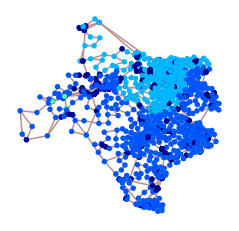

<Figure size 432x288 with 0 Axes>

In [8]:
venom = network.buses.v_nom/500
venom.describe()


#p_out = network.generators.p_nom
#p_out.describe()
#bus_colors = pd.Series("r", network.buses.index)

#network.plot(bus_colors= venom)
#bus_colors[p_out<0] = "b"
#test = network.plot(bus_colors=venom, bus_cmap=plt.cm.jet)
network.plot(bus_colors=venom, bus_cmap=plt.cm.jet)
jet = cm = plt.get_cmap('jet') 
#network.iplot(bus_colors=venom, bus_cmap= jet)
#mpld3.fig_to_html(network)
fig = plt.figure()
#mpld3.plugins.PointHTMLTooltip(network)
#mpld3.plugins.connect(network, PointHTMLTooltip)
#mpld3.display()


In [7]:

#print(network.buses_t.q)
#network.buses_t.q
bus_colors = pd.Series("r",network.buses.index)
bus_colors[p_out == "False"] = "b"

#network.plot(bus_colors=bus_colors,
             title="Reactive power feed-in (red=+ve, blue=-ve)");

NameError: name 'p_out' is not defined

In [ ]:
# Color Scale code plt -> plotly 
magma_cmap = plt.cm.get_cmap('magma')
viridis_cmap = plt.cm.get_cmap('viridis')

viridis_rgb = []
magma_rgb = []
norm = plt.colors.Normalize(vmin=0, vmax=255)

for i in range(0, 255):
       k = plt.colors.colorConverter.to_rgb(magma_cmap(norm(i)))
       magma_rgb.append(k)

for i in range(0, 255):
       k = plt.colors.colorConverter.to_rgb(viridis_cmap(norm(i)))
       viridis_rgb.append(k)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

magma = list(matplotlib_to_plotly(magma_cmap, 255))
viridis = list(matplotlib_to_plotly(viridis_cmap, 255))


In [ ]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        gr.add_node(n)
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=900)
    plt.show()

In [ ]:
#pd.set_option("display.max_rows", 2000)
#pd.options.display.max_rows = 999
#print(network.adjacency_matrix())

network.plot()

print(network.graph())

#plt.pyplab.spy(network)
net_adj_mat = network.adjacency_matrix()
net_arr = net_adj_mat.toarray()
print(net_arr)


#show_graph_with_labels(net_adj_mat)


#G = network.DiGraph(input_data.values)
#network.bus[3001006]


In [ ]:
print("Removing lines")
print(f"Initial number of lines: {network.lines.shape[0]}")
remove_lines_random(network)
print(f"Resulting number of lines: {network.lines.shape[0]}")
print("Removed Lines:")
display(removed_lines)

In [ ]:
print("Disconnecting buses")
print(f"Initial number of lines: {network.lines.shape[0]}")
disconnect_buses_random(network)
print(f"Resulting number of lines: {network.lines.shape[0]}")
print("Removed Lines:")
display(removed_lines)
print("Buses Disconnected:")
display(buses_disconnected)

In [ ]:
print('Reducing Generators Capacity:')
reduce_generators_random(network)
print("Generators Reduced:")
display(reduced_generators)